In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

In [2]:
import torch
from transformers import AutoTokenizer
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import respond_to_batch

from pythainlp.corpus import thai_words
import pandas as pd
import numpy as np

2023-02-24 05:13:45.918764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 05:13:49.068063: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-02-24 05:13:49.068187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-02-24 05:13:49.068200: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [3]:
device = torch.device("cuda") #ppo_trainer.accelerator.device
device

device(type='cuda')

## Tokenizer

In [4]:
import re

def has_thai_char(string):
    thai_char_regex = '[\u0E00-\u0E7F]+'
    return re.search(thai_char_regex, string) is not None

def has_english_char(string):
    english_char_regex = '[\x00-\x7F]+'
    return re.search(english_char_regex, string) is not None

In [5]:
tokenizer_xglm = AutoTokenizer.from_pretrained('facebook/xglm-564M')
tokenizer_mgpt = AutoTokenizer.from_pretrained('sberbank-ai/mGPT')
tokenizer_gptj = AutoTokenizer.from_pretrained('EleutherAI/gpt-j-6B')
#'EleutherAI/gpt-neox-20b', EleutherAI/gpt-j-6B,'EleutherAI/gpt-neo-2.7B'

### Token Granularity

In [6]:
#% thai subwords; xglm
thai_toks = [i for i in tokenizer_xglm.vocab if has_thai_char(i)]
len(thai_toks), len(tokenizer_xglm.vocab), len(thai_toks) / len(tokenizer_xglm.vocab)

(4226, 256008, 0.016507296646979783)

In [7]:
#% eng subwords; xglm
eng_toks = [i for i in tokenizer_xglm.vocab if has_english_char(i)]
len(eng_toks), len(tokenizer_xglm.vocab), len(eng_toks) / len(tokenizer_xglm.vocab)

(143413, 256008, 0.5601895253273336)

In [8]:
#% thai subwords; mgpt
thai_toks = [i for i in tokenizer_mgpt.vocab if has_thai_char(i)]
len(thai_toks), len(tokenizer_mgpt.vocab), len(thai_toks) / len(tokenizer_mgpt.vocab)

(0, 100000, 0.0)

In [9]:
#% eng subwords; mgpt
eng_toks = [i for i in tokenizer_mgpt.vocab if has_english_char(i)]
len(eng_toks), len(tokenizer_mgpt.vocab), len(eng_toks) / len(tokenizer_mgpt.vocab)

(65524, 100000, 0.65524)

In [10]:
#% thai subwords; gptj
thai_toks = [i for i in tokenizer_gptj.vocab if has_thai_char(i)]
len(thai_toks), len(tokenizer_gptj.vocab), len(thai_toks) / len(tokenizer_gptj.vocab)

(0, 50400, 0.0)

In [11]:
#% eng subwords; gptj
eng_toks = [i for i in tokenizer_gptj.vocab if has_english_char(i)]
len(eng_toks), len(tokenizer_gptj.vocab), len(eng_toks) / len(tokenizer_gptj.vocab)

(49565, 50400, 0.9834325396825396)

In [12]:
thai_words_df = pd.DataFrame({'thai_word': list(thai_words())})
thai_words_df['xglm_tokens'] = thai_words_df\
    .thai_word.map(lambda x: [tokenizer_xglm.decode(i) for i in tokenizer_xglm.encode(x)])
thai_words_df['xglm_nb_tokens'] = thai_words_df['xglm_tokens'].map(lambda x: len(x))
thai_words_df['mgpt_tokens'] = thai_words_df\
    .thai_word.map(lambda x: [tokenizer_mgpt.decode(i) for i in tokenizer_mgpt.encode(x)])
thai_words_df['mgpt_nb_tokens'] = thai_words_df['mgpt_tokens'].map(lambda x: len(x))
thai_words_df['gptj_tokens'] = thai_words_df\
    .thai_word.map(lambda x: [tokenizer_gptj.decode(i) for i in tokenizer_gptj.encode(x)])
thai_words_df['gptj_nb_tokens'] = thai_words_df['gptj_tokens'].map(lambda x: len(x))

In [13]:
thai_words_df.head(10)

,thai_word,xglm_tokens,xglm_nb_tokens,mgpt_tokens,mgpt_nb_tokens,gptj_tokens,gptj_nb_tokens
0,ปอ.พ.,"[</s>, , ปอ, ., พ, .]",6,"[ป, อ, ., พ, .]",5,"[�, �, �, �, ., �, �, .]",8
1,การพร่อง,"[</s>, การ, พร, ่อง]",4,"[การ, พร, ่, อง]",4,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, �]",16
2,นักษัตรโยค,"[</s>, น, ักษ, ัตร, โย, ค]",6,"[น, ั, กษ, ั, ตร, โย, ค]",7,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",20
3,เคลี้ยคลิง,"[</s>, , เคล, ี้ย, ค, ลิง]",6,"[เคล, ี้, ย, คล, ิ, ง]",6,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",20
4,ผู้วิจารณ์,"[</s>, ผู้, วิจ, ารณ์]",4,"[ผ, ู้, ว, ิ, จ, ารณ, ์]",7,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",20
5,ยัชมาน,"[</s>, ย, ัช, มาน]",4,"[ย, ั, ช, ม, าน]",5,"[�, �, �, �, �, �, �, �, �, �, �, �]",12
6,มาลัยชายเดียว,"[</s>, ม, าลัย, ชาย, เดียว]",5,"[ม, าล, ั, ย, ชาย, เด, ี, ยว]",8,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, ...",26
7,จ้างงาน,"[</s>, , จ้าง, งาน]",4,"[จ, ้, าง, งาน]",4,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �]",14
8,บันดาลใจ,"[</s>, บ, ัน, ดา, ล, ใจ]",6,"[บ, ั, นด, าล, ใจ]",5,"[�, �, �, �, �, �, �, �, �, �, �, �, �, �, �, �]",16
9,เอ่ย,"[</s>, เอ, ่ย]",3,"[เอ, ่, ย]",3,"[�, �, �, �, �, �, �, �]",8


<AxesSubplot:>

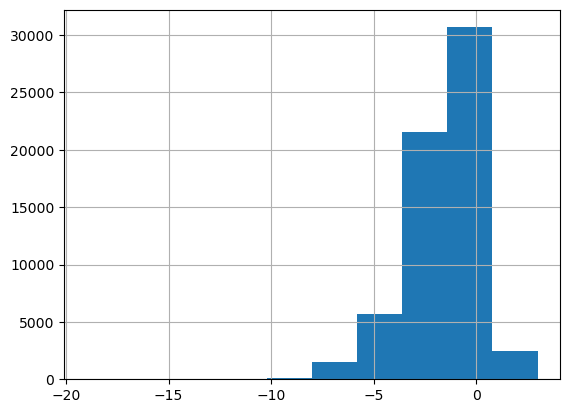

In [14]:
thai_words_df['diff_nb_tokens'] = thai_words_df.xglm_nb_tokens - 1 - thai_words_df.mgpt_nb_tokens
thai_words_df.diff_nb_tokens.hist(bins=10)

In [15]:
#about 80% of the cases xglm tokenizes to fewer tokens
np.percentile(thai_words_df.diff_nb_tokens, np.arange(0, 100, 10))

array([-19.,  -4.,  -3.,  -2.,  -2.,  -1.,  -1.,  -1.,   0.,   0.])

### Fitting Sequence Length

In [16]:
from datasets import load_dataset

iapp = load_dataset('iapp_wiki_qa_squad')
iapp

Found cached dataset iapp_wiki_qa_squad (/home/charipol/.cache/huggingface/datasets/iapp_wiki_qa_squad/iapp_wiki_qa_squad/1.0.0/c1455d806e5a66ca9ee5c03b4aeaeaef4410afca6263c0bfb440ff1db28e20c3)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 5761
    })
    validation: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 742
    })
    test: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 739
    })
})

In [17]:
ds = []
for i in iapp['train']:
    ds.append({'concat': f"C: {i['context']} Q:{i['question']} A:{i['answers']['text'][0]}"})
iapp_df = pd.DataFrame(ds)
iapp_df['nb_tokens'] = iapp_df.concat.map(lambda x: len(tokenizer_xglm.encode(x)))

Token indices sequence length is longer than the specified maximum sequence length for this model (2196 > 2048). Running this sequence through the model will result in indexing errors


In [18]:
#90% is less than 563 tokens
np.percentile(iapp_df.nb_tokens, np.arange(0, 100, 10))

array([ 41., 106., 142., 179., 215., 255., 298., 346., 427., 563.])

In [19]:
(iapp_df.nb_tokens>512).mean(), iapp_df.shape

(0.12324249262280854, (5761, 2))

<AxesSubplot:>

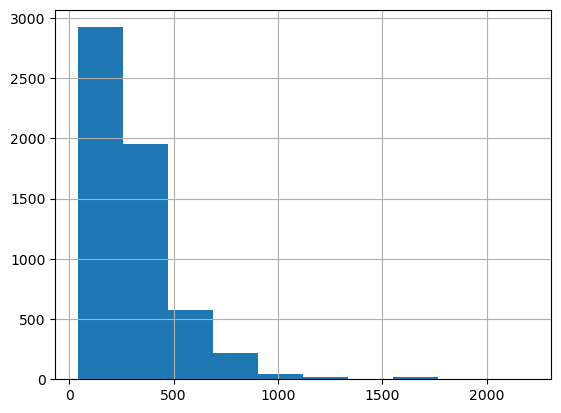

In [20]:
iapp_df['nb_tokens'].hist()

## Few-shot Inferences

In [27]:
pretrained = 'facebook/xglm-564M'
tokenizer = AutoTokenizer.from_pretrained(pretrained)
model = AutoModelForCausalLMWithValueHead.from_pretrained(pretrained).to(device)
model_ref = create_reference_model(model).to("cuda")

In [28]:
# initialize trainer
ppo_config = PPOConfig(
    batch_size=1,
    forward_batch_size=1
)
ppo_trainer = PPOTrainer(ppo_config, model, model_ref, tokenizer)

In [29]:
# encode a query
query_txt = "Q: ทีมไรเมพสุดในเกาะอังกฤษ A:"
query_tensor = tokenizer.encode(query_txt, return_tensors="pt").to(device)

# get model response
response_tensor  = respond_to_batch(model_ref, query_tensor,
                                   txt_len=512, top_k=0, top_p=1.,
                                   end=2)
tokenizer.decode(response_tensor[0])

'</s> Q: ทีมไรเมพสุดในเกาะอังกฤษ A: เราอาจจะเลือกเกมที่ต้องการแข่งน้อยกว่าคู่ต่อสู้ของเราในช่วงครึ่งแรก</s>'

In [30]:
# encode a batch of queries
query_txt = ["Q: ทีมฟุตบอลทีมไหนเก่งที่สุดในเกาะอังกฤษ? A:" for i in range(16)]
query_tensor = tokenizer(text=query_txt, return_tensors="pt").to(device)

In [31]:
%%time
response_tensor  = respond_to_batch(model_ref, query_tensor['input_ids'],
                                   txt_len=128, top_k=0, top_p=1.)

CPU times: user 16.4 s, sys: 6.42 s, total: 22.8 s
Wall time: 17.4 s


In [32]:
tokenizer.batch_decode(response_tensor)

['เดอะเชฟฟิลด์ เวนเจอร์ส กรุณาแย่งตําแหน่ง</s> ถ้าราวี” ผลงานโดดเด่น ผลงานล่าสุดในเอเอฟซีแชมเปี้ยนส์ลีก 6 เกมหลังสุดทําประตู 36, จบ 45 นัด</s> โชเซ่ มูรินโญ่ กุนซือชาวโปรตุเกส แชมป์แชมป์ลีก 2 สมัย ในอาคันตุกะตลอด 8 ปีที่สร้างชื่อด้วยการพาทีมคว้าแชมป์ลีกมา 1 ฤดูกาลก่อน ปรากฎว่าผลงานฤดูนี้ดร็อปให้เห็นจนได้ จากฟอร์ม 9 นัด 19 ประตู</s> เริ่มเกมขึ้นมาเพียง 2 นาที มีผู้เล่นเพียง 10 คน',
 'ฮิลล์ ยูไนเต็ด (Ireland) - ชนะ Lancaster Rovers (England) 3-2, Richmond Rovers (England) ชนะ Notts County (South Wales) 2-2, Theysley Sneijder (Germany) ชนะ Bristol City (England) 0-1, เสีย <unk>10 ล้านให้ BSkyB 848 เท่า zur Woche (อังกฤษ 3%), Edeians (Netherlands) - ชนะ <unk>20 ล้านให้ EDC (Nordic • European) 388 เท่า zur Woche (อังกฤษ 7%), <unk>30 ล้านให้ เอล ซัลโล (Holland • Holland) ',
 'ไป</s> 2.ราชสดุดีสุทธารดลย์ ชนะเยอรมัน 4:1</s> 3.เยอรมันคว้าถ้วยลงประเมิณ ได้เดนเวอร์,</s> 4.เพื่อนร่วมทีมที่ดีที่สุดทีมหนึ่ง ชนะลิเมอรัล พรีเมียร์ลีก ชนะพอร์ทแลนด์ 3-2</s> 5. โมวิช จีบเคร๊มเปิล ชนะเวลส์ ออร์แลน 2-0</s>

## Create Dataset Object

In [39]:
from datasets import Dataset

# Define the file path
all_df = pd.read_csv('../data_large/all_df.csv')
all_df['body'] = all_df['body'].map(lambda x: x.split('แก้ไขข้อความเมื่อ')[0])
all_df['comment'] = all_df['comment'].map(lambda x: x.split('แก้ไขข้อความเมื่อ')[0])

# # Create a Hugging Face dataset from the list of lines
# dataset = Dataset.from_dict({"text": lines})

In [42]:
all_df.head()

,datasource_url_x,content_id,type_x,title,body,total_field,tags,like_score_x,feel_heart_x,feel_laugh_x,...,type_y,comment,like_score_y,feel_heart_y,feel_laugh_y,feel_love_y,feel_sad_y,feel_horror_y,feel_wow_y,nb_interact
0,https://pantip.com/topic/36188003,36188003,content,ส่งDMในทวิตไม่ได้ ทำยังไงดี?,DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินก...,4,"Social Network,Twitter",0,0,0,...,comment,ส่งหาใครคะ ดีเอ็มต้องโฟโลทั้งสองฝ่ายปะอะ,0,0,0,0,0,0,0,0
1,https://pantip.com/topic/36188003,36188003,content,ส่งDMในทวิตไม่ได้ ทำยังไงดี?,DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินก...,4,"Social Network,Twitter",0,0,0,...,comment,ไม่ต้อง follow กันและกัน ก็ส่งได้นะส่งมาแล้วแต...,0,0,0,0,0,0,0,0
2,https://pantip.com/topic/36188003,36188003,content,ส่งDMในทวิตไม่ได้ ทำยังไงดี?,DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินก...,4,"Social Network,Twitter",0,0,0,...,comment,จขกท.แก้ได้ยังค่ะ เราก็เปน ฝากด้วยนะคะ(แต่เราส...,0,0,0,0,0,0,0,0
3,https://pantip.com/topic/36188003,36188003,content,ส่งDMในทวิตไม่ได้ ทำยังไงดี?,DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินก...,4,"Social Network,Twitter",0,0,0,...,comment,แก้ได้ยังคะ?เราก็เป็น,0,0,0,0,0,0,0,0
4,https://pantip.com/topic/36188206,36188206,content,ใช้เน็ตบ้านทรูขึ้น ERR_CONNECTION_RESET บ่อยม...,ใช้เน็ตบ้านทรูขึ้น ERR_CONNECTION_RESET บ่อยม...,3,"อินเทอร์เน็ต,ADSL,Network,true online,Wi-Fi",0,0,0,...,comment,ไม่ไหว เบื่อ ที่เรียกซ่อม,0,0,0,0,0,0,0,0


In [60]:
all_df[x==4]

,datasource_url_x,content_id,type_x,title,body,total_field,tags,like_score_x,feel_heart_x,feel_laugh_x,...,type_y,comment,like_score_y,feel_heart_y,feel_laugh_y,feel_love_y,feel_sad_y,feel_horror_y,feel_wow_y,nb_interact
2087421,https://pantip.com/topic/30523238,30523238,content,ก่อนไปเลบานอน ขอตั้งกระทู้ถามเพื่อนๆก่อนนอนสัก...,เนื่องจากกระทู้การเมือง กระทู้นึงตั้งกระทู้โดย...,19,การเมือง,7,22,0,...,comment,จองงงงงงงง,1,6,0,1,0,0,0,8
2087422,https://pantip.com/topic/30523238,30523238,content,ก่อนไปเลบานอน ขอตั้งกระทู้ถามเพื่อนๆก่อนนอนสัก...,เนื่องจากกระทู้การเมือง กระทู้นึงตั้งกระทู้โดย...,19,การเมือง,7,22,0,...,comment,จอง กันคุณข้างบูรพา(ร้อนหนาว)ครับ ยิ้ม,0,2,3,1,0,0,0,6
2087423,https://pantip.com/topic/30523238,30523238,content,ก่อนไปเลบานอน ขอตั้งกระทู้ถามเพื่อนๆก่อนนอนสัก...,เนื่องจากกระทู้การเมือง กระทู้นึงตั้งกระทู้โดย...,19,การเมือง,7,22,0,...,comment,จินตนการไม่ผิดหรอกพี่ข้างฯแต่ไอ้ที่ผิดเนี้ยคนพ...,0,5,11,0,0,0,0,16
2087424,https://pantip.com/topic/30523238,30523238,content,ก่อนไปเลบานอน ขอตั้งกระทู้ถามเพื่อนๆก่อนนอนสัก...,เนื่องจากกระทู้การเมือง กระทู้นึงตั้งกระทู้โดย...,19,การเมือง,7,22,0,...,comment,น้องนพ ใจเย็นๆค่ะ[Spoil] คลิกเพื่อดูข้อความที่...,0,1,8,2,0,0,0,11
2087425,https://pantip.com/topic/30523238,30523238,content,ก่อนไปเลบานอน ขอตั้งกระทู้ถามเพื่อนๆก่อนนอนสัก...,เนื่องจากกระทู้การเมือง กระทู้นึงตั้งกระทู้โดย...,19,การเมือง,7,22,0,...,comment,น้องนพฯ อย่าไปสนใจเลย คนบางคนรูปชั่ว ตัวดำ ใจย...,0,6,0,1,0,0,0,7


In [35]:
sample_df = all_df[all_df.nb_interact>0][['title','body','comment','nb_interact']]\
                .head(1000).reset_index(drop=True)
sample_df.sort_values('nb_interact',ascending=False)

,title,body,comment,nb_interact
107,เจอบางอย่างขณะซักเสื้อผ้าแฟน,วันหยุด ก็จะซักผ้า เป็นเรื่องปกติ ซักตาก ซักตา...,เอ้าคุณไม่รู้อะไรน้ำตาลไว้ฉีกกินก่อนซั่มกับหญิ...,362
109,เจอบางอย่างขณะซักเสื้อผ้าแฟน,วันหยุด ก็จะซักผ้า เป็นเรื่องปกติ ซักตาก ซักตา...,จขกท ปกติซักเสื้อผ้าแฟนรวมกับผ้าขี้ริ้วผ้าเช็ด...,341
108,เจอบางอย่างขณะซักเสื้อผ้าแฟน,วันหยุด ก็จะซักผ้า เป็นเรื่องปกติ ซักตาก ซักตา...,โชคดีที่วันนั้นเมา...เลยหยิบมาผิด รอดไปที (เฮ้อ),191
277,เมื่อผมเมียน้อย 2 ปีแล้ว.โดยที่เมียหลวงไม่เคยร...,1แก้ไขข้อความเมื่อ,เลวทั้งคู่,178
964,ขอคำปรึกษาค่ะ ลูกสาวแชทกับเพื่อนด้วยบทสนทนา 18+,สวัสดีค่ะเพื่อนๆชาวพันทิปทุกท่าน มีเรื่องมาปรึ...,จริงๆ น้องเค้าก็ไม่ได้ไร้ยางอายซะทีเดียวนะครับ...,150
...,...,...,...,...
401,ใครเบื่อพวกกิยาคุมฉุกเฉินแล้วมาถามว่าจะท้องไหม...,เราเข้าใจคนท่ลุ้นมีลูกนะก็อยากมีเพื่อนช่วยลุ้น...,เราแค่แปลกใจว่าเค้ามาถามคนแปลกหน้าทำไม เชื่อได...,1
404,ขอคำแนะนำร้านที่รับทำรูปให้เป็นแบบปักผ้าครอสติ...,จะปักครอสติสที่กระเป๋าผ้ากันเปื้อนให้ลูกค่ะ แต...,ขอบคุณค่ะ ^_^,1
406,เมื่อเพื่อนสาวของคุณแอบโทรหาสามีคุณ,คุณภรรยาทั้งหลายที่เพื่อนสาวของคุณโทร ไลน์ คุย...,คิดมาก ถ้าบ่อยๆ ครั้ง ค่อยแสดงตัวจับกุม มิให้เ...,1
407,เมื่อเพื่อนสาวของคุณแอบโทรหาสามีคุณ,คุณภรรยาทั้งหลายที่เพื่อนสาวของคุณโทร ไลน์ คุย...,ท่าทางเพื่อนหวังตีท้ายครัวคุณนะคะระวังให้ดีๆ,1


In [41]:
sample_df['nb_token_title'] = sample_df.title\
    .map(lambda x: len([tokenizer.decode(i) for i in tokenizer.encode(x)]))
sample_df['nb_token_body'] = sample_df.body\
    .map(lambda x: len([tokenizer.decode(i) for i in tokenizer.encode(x)]))
sample_df['nb_token_comment'] = sample_df.comment\
    .map(lambda x: len([tokenizer.decode(i) for i in tokenizer.encode(x)]))

Token indices sequence length is longer than the specified maximum sequence length for this model (2812 > 2048). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

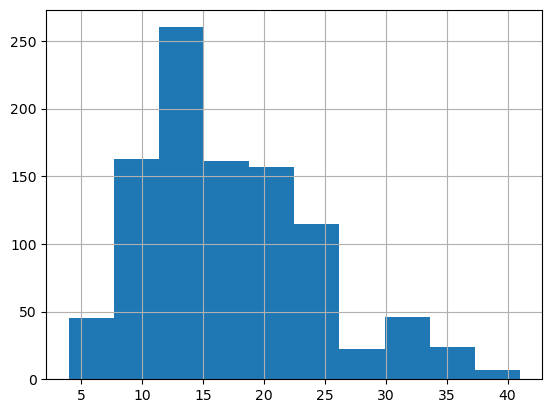

In [42]:
sample_df.nb_token_title.hist()

<AxesSubplot:>

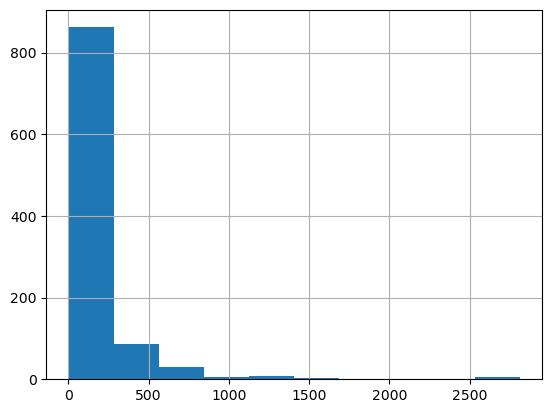

In [43]:
sample_df.nb_token_body.hist()

<AxesSubplot:>

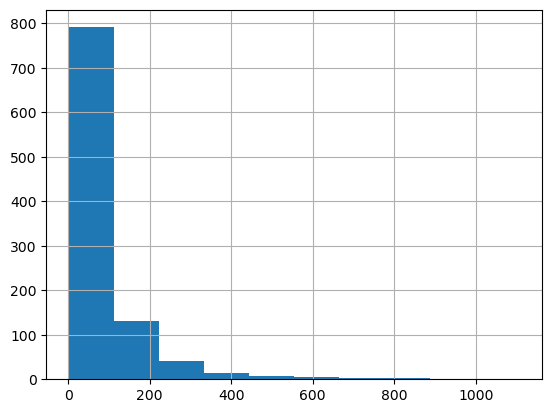

In [44]:
sample_df.nb_token_comment.hist()

<AxesSubplot:>

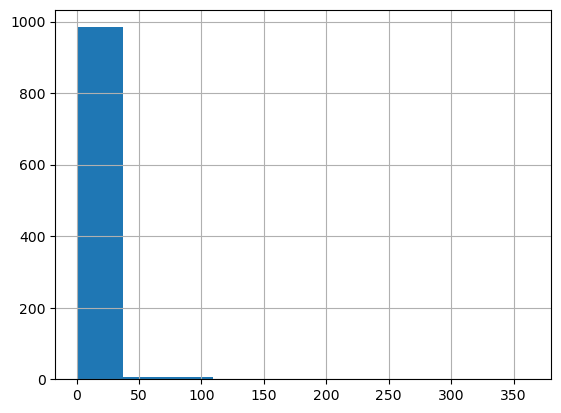

In [45]:
sample_df.nb_interact.hist()

In [47]:
sample_df.sort_values('nb_token_comment',ascending=False)

,title,body,comment,nb_interact,nb_token_title,nb_token_body,nb_token_comment
702,รบกวนถามเรื่องชื่อ ความหมาย และวันเปลี่ยนชื่อใ...,คืออยากเปลี่ยนชื่อเสริมกำลังใจ และเผื่อว่าจะด...,ณ เกิดวันอาทิตย์ วรรคศรี ไม่เหมาะกับผู้ชาย น...,1,16,215,1108
867,High Speed Internet ที่บ้านโดนตัด,เดิมใช้ High Speed Internet ของ True มาประมาณ ...,ไม่มี อินเทอร์เน็ต รายไหน ดีที่สุด มีเบอร์ ราย...,1,8,335,907
622,ของใช้สำหรับเด็กอ่อน ต้องซื้ออะไรบ้างครับ แล้ว...,ตอนนี้ภรรยาท้องประมาณ 10 สัปดาห์ครับอยากรู้ว่า...,ถ้าเอาแบบประหยัด ประสบการณ์ตรงนะครับถุงเท้า แ...,2,15,50,884
46,New Macbook / Macbook Air / Surface Pro4 ตัวไห...,คือ อยากทราบว่า notebook ใน งบ 50 k ตัวไหนเหมา...,ตอบ คห 7 ถ้าไม่เกี่ยงแบต ก็ต้องตอบคำถามของ คห ...,2,17,108,871
976,รบกวน อาจารย์ศุภชัย ครับ ช่วยแนะนำ Printer Al...,พอดีผมกำลังเปิดบริษัทเล็กๆต้องใช้งาน ปริ้นแคตต...,ขอตอบแบบคนทำร้าน ที่เคยใช้มาทุกยี่ห้อ และซ่อมเ...,2,20,62,847
...,...,...,...,...,...,...,...
78,ตามหาเกมนึงครับ ค่อนข้างเก่าแต่ไม่มาก,ตามหัวข้อเลยครับ เกมเป็นเกมเดินสู้-ตัวละครมีเย...,Little Fighter,1,13,103,3
398,สอบถามราคาค่าคลอด รพ.นพรัตน์ ด้วยค่ะ และการเตร...,กำหนดคลอด เมษา 58 นี้ ถ้าจะคลอดที่ รพ.นพรัตน์ ...,ขอบคุณค่ะ,1,22,49,3
787,3BB เปลี่ยนจาก VDSL 50/20 ไป FTTx 50/10 มีคำตอ...,รายละเอียดตามตารางเลยครับราคาคิดรวม VAT แล้วจะ...,ครับ,1,22,23,2
311,SSD กับ HDD อันไหนทน ไฟฟ้าตก ไฟฟ้สกระชาก ได้มา...,SSD กับ HDD อันไหนทน ไฟฟ้าตก ไฟฟ้สกระชาก ได้มา...,UPS,1,21,21,2


In [51]:
sample_df.iloc[622].comment

'ถ้าเอาแบบประหยัด  ประสบการณ์ตรงนะครับถุงเท้า แทบไม่เคยได้ใส่ครับ  ถุงมือนี่กันข่วนหน้าสำคัญมาก แต่ถุงเท้านี่แทบไม่มีประโยชน์อะไรเลย เพราะน้องยังเดินไม่ได้อีกนานครับกางเกง ของผมก็ไม่ได้ใส่ครับ ใส่แต่ผ้าอ้อม ไม่ก็ผ้าอ้อมสำเร็จรูป  วันนึงเด็กทารกแรกเกิดจะถ่ายมากกว่า 7-8 ครั้ง ใน 24 ชั่วโมงนอนอยู่แต่ในบ้าน แปปๆก็เปลี่ยนผ้าอ้อมแล้ว บอกเลยว่าไม่ได้มีประโยชน์เท่าไหรหรอกมันจะมีผ้ากันเปื้อนเด็กอีก -.- ไม่ได้ใช้ครับ น้องกินแต่นม ซื้อเป็นผ้าเช็ดปากมาแทนครับเสื้อเด็กอ่อน  ให้เน้นเป็นแบบผูกเชือกครับ จะถอดง่าย ไม่ต้องซื้อแพง เพราะใส่ได้แค่ 2-3 เดือนต้องเปลี่ยนไซค์แล้วเด็กทารก จาก 1 เดือนไป 2 เดือน น้ำหนักเพิ่มขึ้น 1+ กิโลกรัมครับ  แปปๆ เสื้อคับแล้ว วันนึงใช้เสื้อประมาณ 2 ตัว กลางวัน 1 กลางคืน 1ลองคำนวณเอาว่ามีเวลาซักมากแค่ไหน เท่านั้นหละเสื้อไม่ต้องซื้อแบบ หนา แขนยาว แขนสามส่วนนะครับ  แขนสั้น แขนกุดโลด  เมืองไทยโคตรร้อน ไม่ได้ใส่แน่นอนแขนขาว ผ้าหนา ทั้งหลายนอนห้องแอร์ก็ห่มผ้าครับ -.-  ผมซื้อมาให้ลูกใส่นอนห้องแอร์นะ ตื่นมาตอนเช้าเหงื่อท่วมเสื้ออะผ้าสาลู ซื้อครับ 2-3 โหล ( ถ้ากะจะเอาเป็นผ้าอ้อม ให้คำ

In [ ]:
แก้ไขข้อความเมื่อ